# CNN CIFAR10 

In [2]:
'''
Loadind necessary libraries
'''
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
'''
Loading datasets
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data/data_cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data/data_cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data_cifar10/cifar-10-python.tar.gz to ./data_cifar10
Files already downloaded and verified


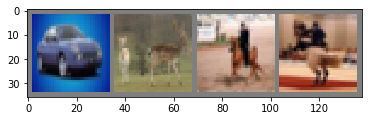

  car  deer horse horse


In [21]:
'''
Plot samples
'''
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
'''
Define model class
'''
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 16, 5)
        
        self.pool = nn.MaxPool2d(2,2)
        self.activation = nn.ReLU()
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [25]:
'''
Setup parameters 
'''
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_epochs = 2

net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
'''
Training loop
'''
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device), data[1].to(device) 
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('{:3d}. {:3.3f}. loss: {:3.3f}'.format(epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Done.')

  1. 2000.000. loss: 1.611
  1. 4000.000. loss: 1.528
  1. 6000.000. loss: 1.448
  1. 8000.000. loss: 1.404
  1. 10000.000. loss: 1.363
  1. 12000.000. loss: 1.321
  2. 2000.000. loss: 1.250
  2. 4000.000. loss: 1.240
  2. 6000.000. loss: 1.248
  2. 8000.000. loss: 1.196
  2. 10000.000. loss: 1.167
  2. 12000.000. loss: 1.185
Done.


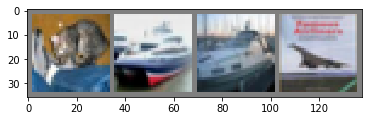

GroundTruth:    cat  ship  ship plane
Predicted:      cat  ship   car plane


In [28]:
'''
Get test sample
'''
images, labels = next(iter(testloader))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [29]:
'''
Get overall test accuracy
'''
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [30]:
'''
Get accuracy for each class
'''
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 76 %
Accuracy of  bird : 63 %
Accuracy of   cat : 35 %
Accuracy of  deer : 37 %
Accuracy of   dog : 43 %
Accuracy of  frog : 80 %
Accuracy of horse : 61 %
Accuracy of  ship : 65 %
Accuracy of truck : 33 %


# CNN MNITS 

In [3]:
'''
Setup parameters
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_epochs = 3
n_classes = 10
batch_size = 100
lr = 1e-3

In [4]:
'''
Load mnist dataset
'''
# Datasets
train_dataset = torchvision.datasets.MNIST(root='./data/data_mnist', train=True, 
                                          transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data/data_mnist', train=False, 
                                          transform=transforms.ToTensor(), download=True)
# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
'''
Define model class
'''
class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(7*7*32, n_classes) # magic numbers =(
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = ConvNet(n_classes).to(device)

In [6]:
'''
Optimizer and loss function
'''
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [8]:
'''
Model training
'''
total_step = len(train_loader)

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print loss
        if (i+1)%100 ==0:
            print('Epoch [{}/{}], step [{}/{}], loss: {:.4f}'
                 .format(epoch+1, n_epochs, i+1, total_step, loss.item()))

Epoch [1/3], step [100/600], loss: 0.1076
Epoch [1/3], step [200/600], loss: 0.1093
Epoch [1/3], step [300/600], loss: 0.1081
Epoch [1/3], step [400/600], loss: 0.0642
Epoch [1/3], step [500/600], loss: 0.1212
Epoch [1/3], step [600/600], loss: 0.1390
Epoch [2/3], step [100/600], loss: 0.0111
Epoch [2/3], step [200/600], loss: 0.0685
Epoch [2/3], step [300/600], loss: 0.0517
Epoch [2/3], step [400/600], loss: 0.0359
Epoch [2/3], step [500/600], loss: 0.0376
Epoch [2/3], step [600/600], loss: 0.0469
Epoch [3/3], step [100/600], loss: 0.0519
Epoch [3/3], step [200/600], loss: 0.0772
Epoch [3/3], step [300/600], loss: 0.0774
Epoch [3/3], step [400/600], loss: 0.0123
Epoch [3/3], step [500/600], loss: 0.0454
Epoch [3/3], step [600/600], loss: 0.0308


In [11]:
'''
Model test
'''
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test accuracy of the model on 10k test images: {} %'.format(100* correct/total))


Test accuracy of the model on 10k test images: 98.86 %


In [12]:
'''
Save model
'''
torch.save(model.state_dict(), './models/mnist_model.ckpt')